In [1]:
import os
from pathlib import Path, PurePath
import pandas as pd
import numpy as np
import cv2
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [2]:
input_folder = Path("../Data/PBC/")

In [15]:
file_list = [x for x in input_folder.glob('**/*.jpg') if x.is_file() and not x.name.startswith('.') ]
print(len(file_list), ".jpg files in input_folder")
file_list[-1]

17092 .jpg files in input_folder


PosixPath('../Data/PBC/platelet/PLATELET_499850.jpg')

In [16]:
def photo_parser(photo_path):
    """
    Parse a photo_path and identify photo attributes as:
    cell_type : str, name of directory ex: basophil, eosinophil, ....
    cell_code : str, prefix of file ex: BA, EO, ERB, .....
    Photo_id : str, id of photo file
    Photo_path : PosixPath
    Return values in a dict
    """
    path_list = str(photo_path).split("/") # list
    cell_type = str(photo_path).split("/")[-2]
    cell_code = list(filter(lambda v: re.match('.*jpg', v), path_list))[0].split('_')[0]
    Photo_id = list(filter(lambda v: re.match('.*jpg', v), path_list))[0].split('.')[0]
    d = {
        'Cell_type' : cell_type,
        'Cell_code' : cell_code,
        'Photo_id': Photo_id,
        'Photo_path': photo_path
    }
    return d

In [17]:
i = 0
total_to_import = len(file_list)
dataset = []
for photo_path in file_list:
    photo = photo_parser(photo_path)
    dataset.append(photo)
    i += 1

print(f'{i} photos imported over {total_to_import} ({round(100*i/total_to_import, 2)} %) photos in {input_folder}')
# Import du dataset dans une DF
df = pd.DataFrame(dataset)

17092 photos imported over 17092 (100.0 %) photos in ../Data/PBC


In [18]:
print(df.shape)
df.head()

(17092, 4)


,Cell_type,Cell_code,Photo_id,Photo_path
0,basophil,BA,BA_689200,../Data/PBC/basophil/BA_689200.jpg
1,basophil,BA,BA_883452,../Data/PBC/basophil/BA_883452.jpg
2,basophil,BA,BA_382161,../Data/PBC/basophil/BA_382161.jpg
3,basophil,BA,BA_175579,../Data/PBC/basophil/BA_175579.jpg
4,basophil,BA,BA_775722,../Data/PBC/basophil/BA_775722.jpg


In [19]:
df.isna().any()

Cell_type     False
Cell_code     False
Photo_id      False
Photo_path    False
dtype: bool

Statistiques sur les images

In [21]:
def images_stats(photo_path):
    """
    Load an image from photo_path and compute :
    H : Height of the image
    W: Width of the image
    'col'_max : max value of channel 'col'
    'col'_min : min value of chenel 'col
    'col'_mean : mean value of chanel 'col'
    """
    #print(photo_path)
    img = cv2.imread(str(photo_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #plt.imshow(img);
    
    d = {}
    for i in range(2):
        d[str('H')] = img.shape[0]
        d[str('W')] = img.shape[1]

    colors = ['red', 'green', 'blue']
    for i, col in enumerate(colors):
        d[str(col + '_' + 'max')] = np.max(img[:,:,i])
        d[str(col + '_' + 'min')] = np.min(img[:,:,i])
        d[str(col + '_' + 'mean')] = np.mean(img[:,:,i])
        #d[str(col + '_' + 'hist')] = cv2.calcHist(img,[i],None,[256],[0,256])

    return d

In [22]:
stats_df = df['Photo_path'].apply(lambda x: pd.Series(images_stats(x)))

In [23]:
stats_df.head()

,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
0,363.0,360.0,255.0,38.0,220.775620,251.0,0.0,186.915060,216.0,91.0,183.087473
1,363.0,360.0,255.0,43.0,217.682828,243.0,0.0,185.541889,223.0,92.0,183.007713
2,369.0,366.0,255.0,12.0,209.731159,243.0,2.0,187.798829,252.0,106.0,211.670932
3,363.0,360.0,255.0,40.0,221.362297,246.0,0.0,191.259504,221.0,89.0,182.384320
4,363.0,360.0,255.0,40.0,231.950077,251.0,0.0,201.820669,219.0,90.0,188.984519


In [24]:
PBC = pd.concat([df, stats_df], axis=1)
print(PBC.shape)
PBC.head()

(17092, 15)


,Cell_type,Cell_code,Photo_id,Photo_path,H,W,red_max,red_min,red_mean,green_max,green_min,green_mean,blue_max,blue_min,blue_mean
0,basophil,BA,BA_689200,../Data/PBC/basophil/BA_689200.jpg,363.0,360.0,255.0,38.0,220.775620,251.0,0.0,186.915060,216.0,91.0,183.087473
1,basophil,BA,BA_883452,../Data/PBC/basophil/BA_883452.jpg,363.0,360.0,255.0,43.0,217.682828,243.0,0.0,185.541889,223.0,92.0,183.007713
2,basophil,BA,BA_382161,../Data/PBC/basophil/BA_382161.jpg,369.0,366.0,255.0,12.0,209.731159,243.0,2.0,187.798829,252.0,106.0,211.670932
3,basophil,BA,BA_175579,../Data/PBC/basophil/BA_175579.jpg,363.0,360.0,255.0,40.0,221.362297,246.0,0.0,191.259504,221.0,89.0,182.384320
4,basophil,BA,BA_775722,../Data/PBC/basophil/BA_775722.jpg,363.0,360.0,255.0,40.0,231.950077,251.0,0.0,201.820669,219.0,90.0,188.984519


Write csv file

In [25]:
PBC.to_csv('../Data/PBC/PBC.csv', index=False)

## Séparation du jeu de données PBC en 11 classes et conversion en png

In [2]:
input_folder = Path('../Data/PBC')
output_folder = Path('../Data/PBC_11cat')

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        for file in tqdm(subdir.iterdir(),  desc=f"{subdir.parts[-1]}"):
            if file.is_file() and not file.name.startswith('.'):
                tag = file.parts[-1].split('_')[0]
                file_name = file.parts[-1].split('.')[0]
                # rename PLATELET as PLT
                if tag == 'PLATELET':
                    tag = 'PLT'
                    file_name = 'PLT_' + file_name.split('_')[-1]
                # Exclusion de IG et Neutrophil car non clairement identifiés
                if tag not in ['IG', 'NEUTROPHIL']:
                    image = cv2.imread(str(file), cv2.IMREAD_COLOR)
                    Path(output_folder / tag).mkdir(exist_ok=True)
                    save_path = Path(output_folder / tag / str(str(file_name) + '.png'))
                    # Convert the image in png and save
                    cv2.imwrite(str(save_path), image)

basophil: 1218it [00:10, 115.04it/s]
neutrophil: 3330it [00:27, 119.03it/s]
ig: 2895it [00:23, 123.47it/s]
monocyte: 1420it [00:12, 115.63it/s]
eosinophil: 3117it [00:26, 117.15it/s]
erythroblast: 1551it [00:12, 119.72it/s]
lymphocyte: 1214it [00:12, 99.80it/s] 
platelet: 2348it [00:19, 119.87it/s]


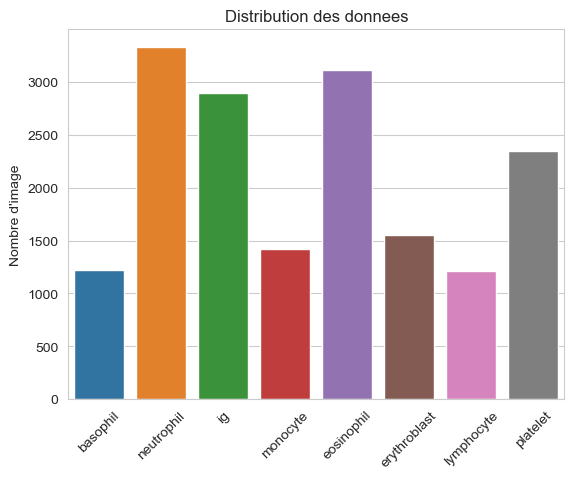

In [3]:
path = input_folder

subdirs = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

# Count the number of files in each subdirectory
file_counts = [len(os.listdir(os.path.join(path, subdir))) for subdir in subdirs]

sns.set_style("whitegrid")
sns.barplot(x=subdirs, y=file_counts)
plt.ylabel("Nombre d'image")
plt.title("Distribution des donnees")
plt.xticks(rotation=45)
plt.show()

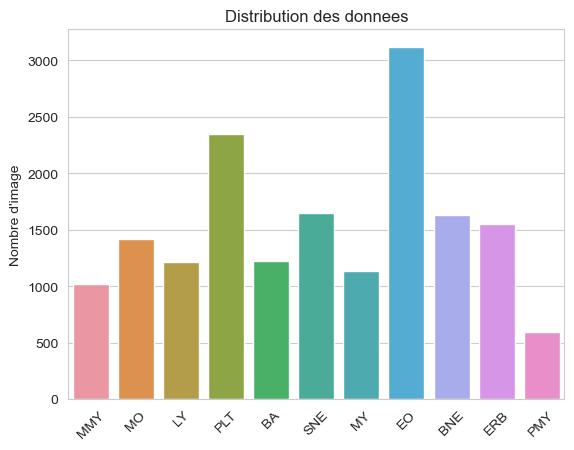

In [53]:
path = output_folder

subdirs = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

# Count the number of files in each subdirectory
file_counts = [len(os.listdir(os.path.join(path, subdir))) for subdir in subdirs]

sns.set_style("whitegrid")
sns.barplot(x=subdirs, y=file_counts)
plt.ylabel("Nombre d'image")
plt.title("Distribution des donnees")
plt.xticks(rotation=45)
plt.show()

## Séparation du jeu de données PBC en 6 classes

In [2]:
input_folder = Path('../Data/PBC')
output_folder = Path('../Data/PBC_6cat')

output_folder.mkdir(exist_ok=True)

for subdir in input_folder.iterdir():
    if subdir.is_dir():
        for file in tqdm(subdir.iterdir(),  desc=f"{subdir.parts[-1]}"):
            if file.is_file() and not file.name.startswith('.'):
                tag = file.parts[-2]
                file_name = file.parts[-1].split('.')[0]
                # Exclusion de IG et Neutrophil car non clairement identifiés
                if tag not in ['ig', 'neutrophil']:
                    image = cv2.imread(str(file), cv2.IMREAD_COLOR)
                    Path(output_folder / tag).mkdir(exist_ok=True)
                    save_path = Path(output_folder / tag / str(str(file_name) + '.png'))
                    # Convert the image in png and save
                    cv2.imwrite(str(save_path), image)

basophil: 1218it [00:10, 119.42it/s]
neutrophil: 3330it [00:00, 47513.86it/s]
ig: 2895it [00:00, 47891.51it/s]
monocyte: 1420it [00:11, 120.58it/s]
eosinophil: 3117it [00:27, 111.72it/s]
erythroblast: 1551it [00:12, 125.18it/s]
lymphocyte: 1214it [00:10, 116.81it/s]
platelet: 2348it [00:20, 115.65it/s]


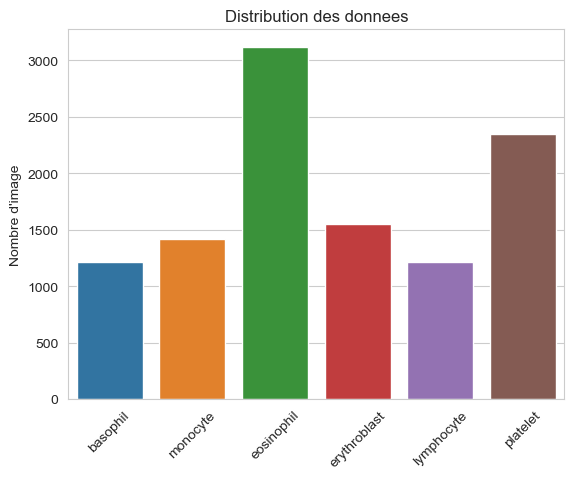

In [3]:
path = output_folder

subdirs = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

# Count the number of files in each subdirectory
file_counts = [len(os.listdir(os.path.join(path, subdir))) for subdir in subdirs]

sns.set_style("whitegrid")
sns.barplot(x=subdirs, y=file_counts)
plt.ylabel("Nombre d'image")
plt.title("Distribution des donnees")
plt.xticks(rotation=45)
plt.show()